# driver_DD_NMROM
Driver to implement and test NM ROM on the 2D Burgers Equation.  
Author: Alejandro Diaz  
Date modified: 1/13/2022

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib import cm
import matplotlib.colors as colors
import scipy.sparse as sp
import scipy.linalg as la
from time import time
import dill as pickle
import os
from utils.Burgers2D_probgen import Burgers2D
from utils.domain_decomposition import DD_model
from utils.LS_ROM import compute_bases_from_svd, DD_LS_ROM
from utils.NM_ROM import DD_NM_ROM, separate_snapshots, compute_residual_bases, RBFmdl
from scipy.interpolate import RBFInterpolator

In [34]:
data_dir = './data/'
plt.rc('font', size=20)
plt.rcParams['text.usetex'] = True

## Set model parameters

In [35]:
# define constant parameters for PDE
nx, ny  = 480, 24
x_lim   = [-1.0, 1.0]
y_lim   = [0.0, 0.05]

na1, nlam = 80, 80
a1_lim  = [1.0, 10000.0]
lam_lim = [5.0, 25.0]
# A, Lam  = np.meshgrid(np.linspace(a1_lim[0], a1_lim[1], na1), np.linspace(lam_lim[0], lam_lim[1], nlam))
# Mu      = np.vstack([A.flatten(), Lam.flatten()]).T

a1, lam = 7692.5384, 21.9230
viscosity = 1e-1

# number of subdomains in x and y directions for DD model
n_sub_x = 2
n_sub_y = 2

n_sub   = n_sub_x*n_sub_y
fig_dir = f'./figures/nx_{nx}_ny_{ny}_mu_{viscosity}_{n_sub_x}x_by_{n_sub_y}y/'
svd_dir = f'./data/nx_{nx}_ny_{ny}_mu_{viscosity}_{n_sub_x}x_by_{n_sub_y}y/'
nm_figs = fig_dir + 'nmrom/'
for d in [fig_dir, nm_figs]:
    if not os.path.exists(d):
        os.mkdir(d)

In [36]:
# load snapshot and residual data
file = f'./data/residual_nx_{nx}_ny_{ny}_mu_{viscosity}_Nsamples_{400}.p'
data = pickle.load(open(file, 'rb'))
Mu = data['parameters']
snapshots = data['snapshots']
residuals = data['residuals']


## Solve DD FOM

In [37]:
# compute FOM for given a1 and lambda
def u_exact(x, y):
    phi = a1 + a1*x + (np.exp(lam*(x-1.0)) + np.exp(-lam*(x - 1.0)))*np.cos(lam*y)
    val = -2.0*viscosity*(a1 + lam*(np.exp(lam*(x-1.0)) \
          - np.exp(-lam*(x - 1.0)))*np.cos(lam*y))/phi
    return val
def v_exact(x, y):
    phi = a1 + a1*x + (np.exp(lam*(x-1.0)) + np.exp(-lam*(x - 1.0)))*np.cos(lam*y)
    val =  2.0*viscosity*(lam*(np.exp(lam*(x-1.0)) \
           + np.exp(-lam*(x - 1.0)))*np.sin(lam*y))/phi
    return val

# generate Burgers FOM on full domain
fom = Burgers2D(nx, ny, x_lim, y_lim, viscosity, u_exact, v_exact)
print('Solving full domain model:')
u_fom, v_fom, res_hist = fom.solve(np.zeros(fom.nxy), np.zeros(fom.nxy), tol=1e-8, print_hist=False)
sol_fd = np.concatenate([u_fom, v_fom])

# compute Burgers DD FOM
ddmdl = DD_model(fom, n_sub_x, n_sub_y)
ndof_fom = 2*np.sum([s.n_interior+s.n_interface for s in ddmdl.subdomain]) \
            + ddmdl.subdomain[0].constraint_mat.shape[0]
w0 = np.zeros(ndof_fom)
print('\nSolving DD model:')
print(f'FOM DoF = {ndof_fom-ddmdl.n_constraints}')
u_dd_fom, v_dd_fom, u_intr, v_intr, u_intf, v_intf, lam_fom, fom_time, itr = ddmdl.solve(w0, tol=1e-6, 
                                                                           maxit=15,
                                                                           print_hist=True)
sol_dd_fom = np.concatenate([u_dd_fom, v_dd_fom])

dd_fom_rel_err = np.linalg.norm(sol_dd_fom-sol_fd)/np.linalg.norm(sol_fd)
print(f'\nDD-FOM relative error = {dd_fom_rel_err:1.4e}') 

Solving full domain model:
Starting Newton solver...
Newton solver terminated after 14 iterations with residual 5.9127e-09.

Solving DD model:
FOM DoF = 25056
Starting Newton solver...
iter       Stepsize       Residual
   0       0.000e+00      2.815e+11
   1       1.000e+00      8.885e+09
   2       1.000e+00      1.273e+09
   3       1.000e+00      1.318e+08
   4       1.000e+00      1.119e+07
   5       1.000e+00      9.497e+05
   6       1.000e+00      8.095e+04
   7       1.000e+00      6.929e+03
   8       1.000e+00      5.963e+02
   9       1.000e+00      5.165e+01
  10       1.000e+00      4.507e+00
  11       1.000e+00      3.968e-01
  12       1.000e+00      3.526e-02
  13       1.000e+00      3.172e-03
  14       1.000e+00      3.552e-04
  15       1.000e+00      2.127e-04
Newton failed to converge in 15 iterations.
Newton solver terminated after 15 iterations with residual 2.1273e-04.

DD-FOM relative error = 8.6156e-16


In [38]:
# restrict snapshots to interior and interface subdomains
interior, interface = separate_snapshots(ddmdl, snapshots)

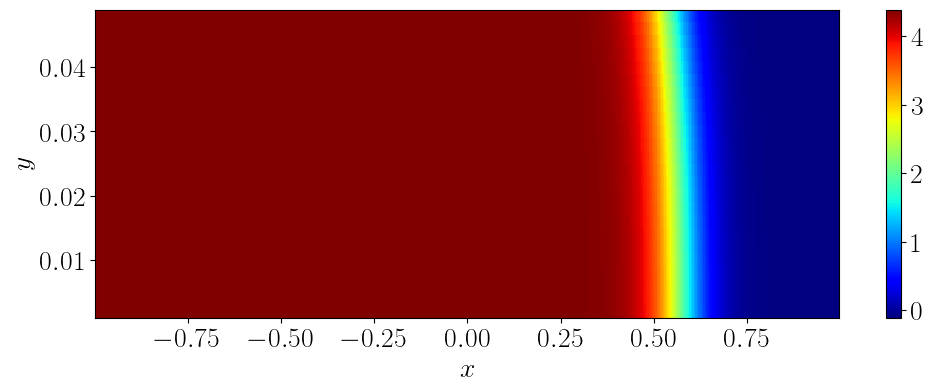

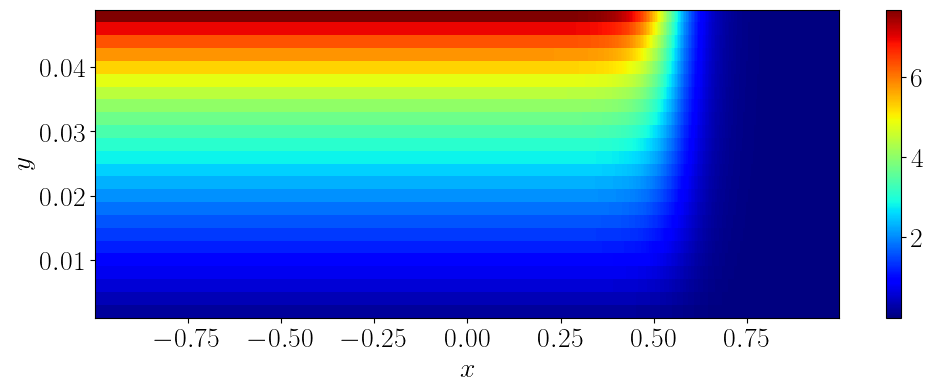

In [39]:
# plot DD FOM u and v
x = np.linspace(x_lim[0], x_lim[1], nx+2)[1:-1]
y = np.linspace(y_lim[0], y_lim[1], ny+2)[1:-1]
X, Y = np.meshgrid(x, y)
U_fom = u_dd_fom.reshape(ny, nx)
V_fom = v_dd_fom.reshape(ny, nx)

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, U_fom, cmap=cm.jet, shading='auto', vmin=u_fom.min(), vmax=u_fom.max())
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$u(x, y)$')
file = fig_dir+'u_fom.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, V_fom, cmap=cm.jet, shading='auto', vmin=v_fom.min(), vmax=v_fom.max())
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$v(x, y)$')
file = fig_dir+'v_fom.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Solve DD NM-ROM

In [40]:
ec     = 1e-8          # energy criteria for number of interior and interface basis vectors
nbasis = -1             # number of residual basis vectors. set to -1 to use energy criteria

# load SVD data
print('Loading residual SVD data...')
res_dict  = pickle.load(open(svd_dir+'res_svd.p', 'rb'))
print('Data loaded!')

# compute bases
print('Computing residual bases...')
residual_bases = compute_bases_from_svd(res_dict, ec=ec, nbasis=nbasis)
print('Bases computed!')

for i in range(n_sub):
    print(f'residual_bases[{i}]={residual_bases[i].shape}')

Loading residual SVD data...
Data loaded!
Computing residual bases...
Bases computed!
residual_bases[0]=(5760, 12)
residual_bases[1]=(5760, 30)
residual_bases[2]=(5760, 16)
residual_bases[3]=(5760, 40)


In [41]:
intr_size = 8
intf_size = 4
intr_rnnz = 5
intf_rnnz = 5
intr_shift = 5
intf_shift = 5
intr_act_type = 'Swish'
intf_act_type = 'Swish'

Ntotal = 6400 if nx in [240, 480] else 4200
net_folder0 = f'./trained_nets/nx_{nx}_ny_{ny}_mu_{viscosity}_{n_sub_x}x_by_{n_sub_y}y/'
intr_net_list = [net_folder0+\
                 f'sub_{i+1}of{n_sub}/interior/'+\
                 f'ld_{intr_size}_rnnz_{intr_rnnz}_rshift_{intr_shift}_'+\
                 f'{intr_act_type}_batch_32_AbsMSEloss_{Ntotal}snaps.p' \
                  for i in range(n_sub)]
intf_net_list = [net_folder0+\
                 f'sub_{i+1}of{n_sub}/interface/'+\
                 f'ld_{intf_size}_rnnz_{intf_rnnz}_rshift_{intf_shift}_'+\
                 f'{intf_act_type}_batch_32_AbsMSEloss_{Ntotal}snaps.p' \
                  for i in range(n_sub)]

print('Building DD NM-ROM...')
ddnmrom = DD_NM_ROM(ddmdl, 
                    intr_net_list,
                    intf_net_list,
                    residual_bases=residual_bases,
                    hr=False, 
                    n_samples=100,
                    n_corners=25, 
                    constraint_type='weak', 
                    n_constraints=1,
                    seed=10)
print('ROM built!\n')

print('Computing RBF interpolant...')
rbfmdl = RBFmdl(ddnmrom, Mu, interior, interface, neighbors=None, kernel='linear')
print('Interpolant computed!')

Building DD NM-ROM...
Using device: cuda
ROM built!

Computing RBF interpolant...
Interpolant computed!


In [42]:
# compute initial iterate using RBF interpolant
initial_time = time()
w_rbf, lam_rbf = rbfmdl.get_initial(np.array([[a1, lam]]), ddnmrom)
w_rbf = np.concatenate([w_rbf, lam_rbf])
initial_time = time()-initial_time

In [43]:
# compute initial iterate for Newton's method 
ndof_rom = np.sum([s.intr_latent_dim+s.intf_latent_dim for s in ddnmrom.subdomain]) \
            + ddnmrom.n_constraints
# w0 = np.zeros(ndof_rom)
w0 = w_rbf

# using encoded FOM solution 
# w0 = []
# for i, s in enumerate(ddnmrom.subdomain):
#     w0.append(s.en_intr(np.concatenate([u_intr[i], v_intr[i]])))
#     w0.append(s.en_intf(np.concatenate([u_intf[i], v_intf[i]])))
# w0.append(np.zeros(ddnmrom.n_constraints))
# w0 = np.concatenate(w0)

# solve DD ROM
print('Solving DD NM-ROM...')
print(f'ROM DoF = {ndof_rom-ddnmrom.n_constraints}')
u_dd_rom, v_dd_rom, w_intr, w_intf, lam_opt, rom_time, itr, rhs_vecs = \
                        ddnmrom.solve(w0, tol=1e-4, maxit=15, print_hist=True, rhs_hist=True)
rom_time += initial_time
print('Solution found!\n')

# compute error
dd_rom_rel_err = ddnmrom.compute_error(w_intr, w_intf, u_intr, v_intr, u_intf, v_intf)
print(f'DD NM-ROM rel. error = {dd_rom_rel_err:1.4e}')
print(f'Speedup = {fom_time/rom_time}')

Solving DD NM-ROM...
ROM DoF = 48
Starting Newton solver...
iter       Stepsize       Residual
   0       0.000e+00      5.226e+11
   1       1.000e+00      9.851e+10
   2       1.000e+00      5.540e+09
   3       1.000e+00      3.602e+08
   4       1.000e+00      2.659e+07
   5       1.000e+00      2.159e+06
   6       1.000e+00      1.754e+05
   7       1.000e+00      1.425e+04
   8       1.000e+00      1.158e+03
   9       1.000e+00      9.405e+01
  10       1.000e+00      7.641e+00
  11       1.000e+00      6.208e-01
  12       1.000e+00      5.053e-02
  13       1.000e+00      4.075e-03
  14       1.000e+00      4.827e-04
  15       1.000e+00      4.413e-04
Newton failed to converge in 15 iterations.
Newton solver terminated after 15 iterations with residual 4.4127e-04.
Solution found!

DD NM-ROM rel. error = 1.2824e-03
Speedup = 6.123306897235935


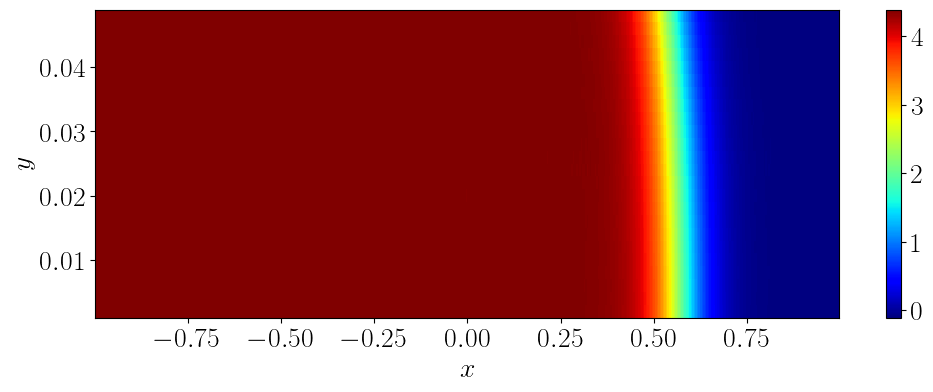

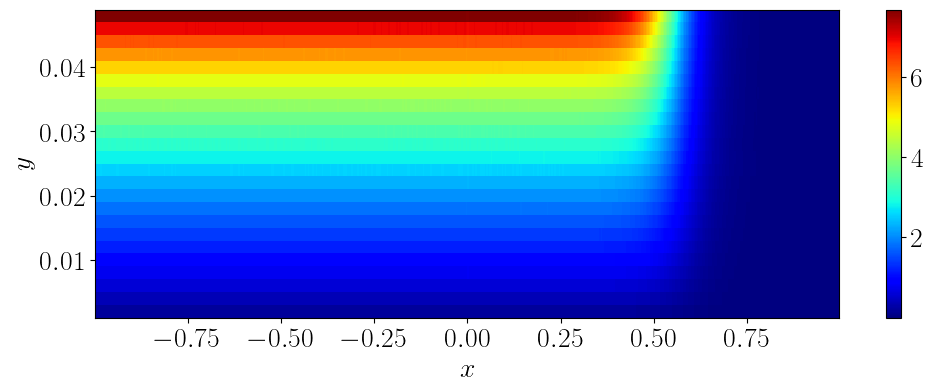

In [44]:
# plot DD ROM u and v
hr_str = '_col_hr' if ddnmrom.hr else ''
x = np.linspace(x_lim[0], x_lim[1], nx+2)[1:-1]
y = np.linspace(y_lim[0], y_lim[1], ny+2)[1:-1]
X, Y = np.meshgrid(x, y)
U_rom = u_dd_rom.reshape(ny, nx)
V_rom = v_dd_rom.reshape(ny, nx)

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, U_rom, cmap=cm.jet, shading='auto', vmin=u_fom.min(), vmax=u_fom.max())
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$u(x, y)$')
file = nm_figs+f'u{hr_str}_state.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, V_rom, cmap=cm.jet, shading='auto', vmin=v_fom.min(), vmax=v_fom.max())
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$v(x, y)$')
file = nm_figs+f'v{hr_str}_state.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

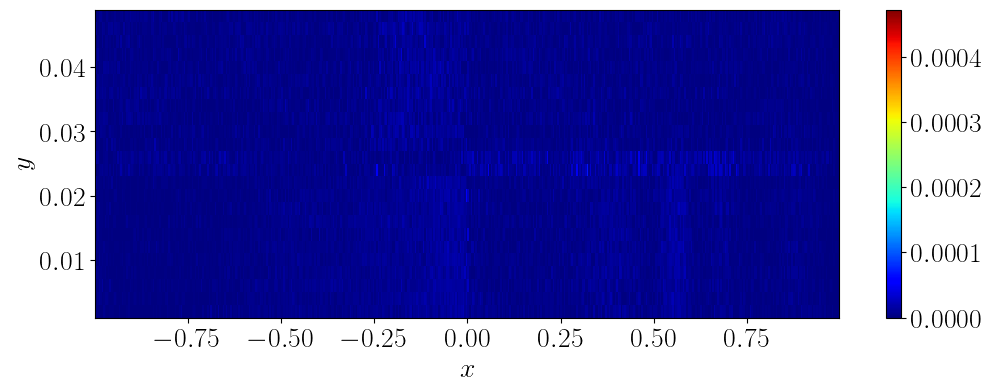

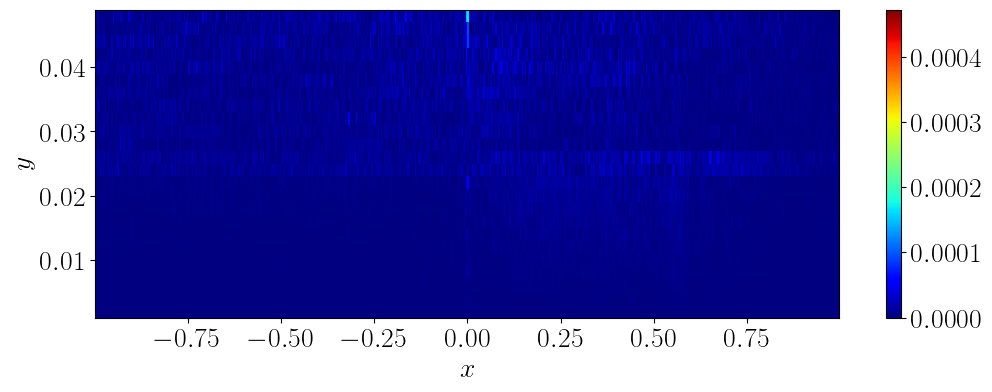

In [45]:
# plot errors
u_rel_err = np.abs(U_fom-U_rom)/np.linalg.norm(U_fom)
plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, u_rel_err, cmap=cm.jet, shading='auto', vmin=0.0, vmax=4.73e-4)
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$u$ Relative error')
file = nm_figs+f'u{hr_str}_rel_error.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12, 4))
v_rel_err = np.abs(V_fom-V_rom)/np.linalg.norm(V_fom)
plt.pcolormesh(X, Y, v_rel_err, cmap=cm.jet, shading='auto', vmin=0.0, vmax=4.73e-4)
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar()#label='$v$ Relative error')
file = nm_figs+f'v{hr_str}_rel_error.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Spy plots of sparsity masks

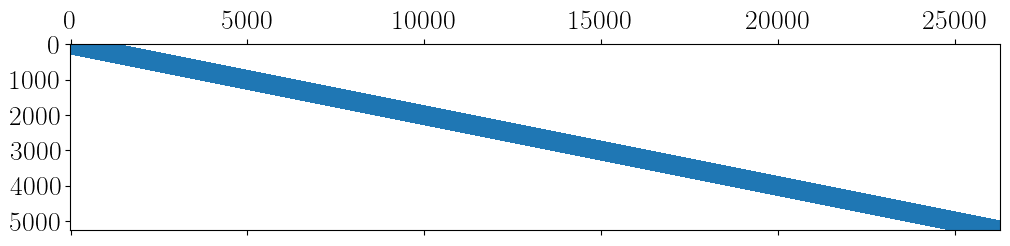

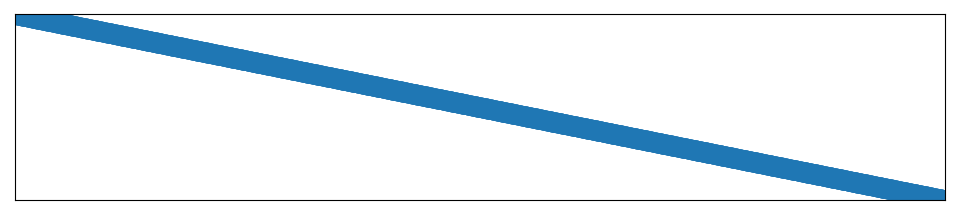

In [46]:
# plot sparsity masks
plt.figure(figsize=(12, 4))
plt.spy(ddnmrom.subdomain[0].de_mask_intr)
file = fig_dir+f'ld_{intr_size}_rnnz_{intr_rnnz}_rshift_{intr_shift}_intr_mask.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(12, 8))
plt.spy(ddnmrom.subdomain[0].de_mask_intf)
plt.xticks([])
plt.yticks([])
file = fig_dir+f'ld_{intf_size}_rnnz_{intf_rnnz}_rshift_{intf_shift}_intf_mask.png'
plt.savefig(file, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Check reconstruction error

In [47]:
error = 0.0
intr_errors = []
intf_errors = []

for i, s in enumerate(ddnmrom.subdomain):
    uv_intr = np.concatenate([u_intr[i], v_intr[i]])
    uv_intf = np.concatenate([u_intf[i], v_intf[i]])
    
    num_intr = np.sum(np.square(uv_intr - s.de_intr(s.en_intr(uv_intr))[0])) 
    num_intf = np.sum(np.square(uv_intf - s.de_intf(s.en_intf(uv_intf))[0])) 
    den_intr = np.sum(np.square(uv_intr)) 
    den_intf =  np.sum(np.square(uv_intf)) 
    intr_errors.append(num_intr/den_intr)
    intf_errors.append(num_intf/den_intf)
    error += (num_intr+num_intf)/(den_intr+den_intf)
    
error = np.sqrt(error/ddnmrom.n_sub)
print(f'Relative reconstruction error = {error:1.4e}\n')
print('Subdomain     Intr. rel. error     Intf. rel. error')
for i in range(n_sub):
    print(f'    {i+1:2d}           {intr_errors[i]:1.4e}           {intf_errors[i]:1.4e}') 

Relative reconstruction error = 2.3011e-03

Subdomain     Intr. rel. error     Intf. rel. error
     1           1.3127e-06           3.9999e-05
     2           1.1690e-06           1.8149e-05
     3           1.4795e-06           3.0943e-06
     4           7.2125e-07           5.1557e-05


## Analyze behavior of residual at FOM and ROM solutions

In [48]:
# compute ROM residual, equality constraint
Ag_rom = np.zeros(ddnmrom.n_constraints)
res_rom = 0.0
res_list = []
for j, s in enumerate(ddnmrom.subdomain):
    res_list.append(s.res_jac(w_intr[j], w_intf[j], lam_opt)[0])
    res_rom += np.linalg.norm(res_list[j])**2
    Ag_rom += s.constraint_mat@s.de_intf(w_intf[j])[0]
res_rom *= 0.5

# compute FOM residual, equality constraint
Ag_fom  = np.zeros(ddmdl.n_constraints)
res_fom = 0.0
for j, s in enumerate(ddmdl.subdomain):
    res_fom += np.linalg.norm(s.res_jac(u_intr[j], v_intr[j], u_intf[j], v_intf[j], lam_fom)[0])**2
    Ag_fom += s.constraint_mat@np.concatenate([u_intf[j], v_intf[j]])
res_fom *= 0.5

print(f'ROM LSTSQ residual  = {res_rom:1.4e}')
print(f'ROM constraint norm = {np.linalg.norm(Ag_rom):1.4e}')
print(f'FOM LSTSQ residual  = {res_fom:1.4e}')
print(f'FOM constraint norm = {np.linalg.norm(Ag_fom):1.4e}')

ROM LSTSQ residual  = 3.6876e+08
ROM constraint norm = 7.1054e-14
FOM LSTSQ residual  = 2.9339e-18
FOM constraint norm = 0.0000e+00


In [49]:
# compute residual, constraint at encoded FOM solution 
Ag_en = np.zeros(ddnmrom.n_constraints)
res_en = 0.0
en_res_list = []
for j, s in enumerate(ddnmrom.subdomain):
    en_uv_intr = s.en_intr(np.concatenate((u_intr[j], v_intr[j])))
    en_uv_intf = s.en_intf(np.concatenate((u_intf[j], v_intf[j])))
    
    en_res_list.append(s.res_jac(en_uv_intr, en_uv_intf, lam_opt)[0])
    res_en += np.linalg.norm(en_res_list[j])**2
    Ag_en += s.constraint_mat@s.de_intf(en_uv_intf)[0]
res_en *= 0.5
print(f'ROM LSTSQ residual at encoded FOM sol.  = {res_en:1.4e}')
print(f'ROM constraint norm at encoded FOM sol. = {np.linalg.norm(Ag_en):1.4e}')

ROM LSTSQ residual at encoded FOM sol.  = 6.7047e+08
ROM constraint norm at encoded FOM sol. = 2.5463e-01


In [50]:
x_err_list = []
res_fom_list = []
res_enc_list = []
RTr_fom_list = []
RTr_enc_list = []
for j, s in enumerate(ddmdl.subdomain):
    res, jac, H, rhs, Ax = s.res_jac(u_intr[j], v_intr[j], u_intf[j], v_intf[j], lam_fom)
    RTr = jac.T@res #np.concatenate([jac_intr.T@res, jac_intf.T@res])
    RTr_fom_list.append(np.linalg.norm(RTr))
    res_fom_list.append(np.linalg.norm(res))
    
    uv_intr_enc = np.concatenate((u_intr[j], v_intr[j]))
    uv_intf_enc = np.concatenate((u_intf[j], v_intf[j]))
    
    uv_intr_enc = ddnmrom.subdomain[j].de_intr(ddnmrom.subdomain[j].en_intr(uv_intr_enc))[0]
    uv_intf_enc = ddnmrom.subdomain[j].de_intf(ddnmrom.subdomain[j].en_intf(uv_intf_enc))[0]
    
    u_intr_enc = uv_intr_enc[:s.n_interior]
    v_intr_enc = uv_intr_enc[s.n_interior:] 
    u_intf_enc = uv_intf_enc[:s.n_interface]
    v_intf_enc = uv_intf_enc[s.n_interface:]
    
    res, jac, H, rhs, Ax = s.res_jac(u_intr_enc, v_intr_enc, u_intf_enc, v_intf_enc, lam_fom)
    RTr = jac.T@res #np.concatenate([jac_intr.T@res, jac_intf.T@res])
    RTr_enc_list.append(np.linalg.norm(RTr))
    res_enc_list.append(np.linalg.norm(res))
    
    x_err_list.append(np.linalg.norm(np.concatenate([u_intr[j], v_intr[j], u_intf[j], v_intf[j]])-
                                    np.concatenate([uv_intr_enc, uv_intf_enc])))
    
print(f"sub.     ||x-x_enc|||    ||r(x)||      ||r(x_enc)||     ||R'(x)^Tr(x)||    ||R'(x_enc)^Tr(x_enc)||")
for j in range(n_sub):
    print(f' {j:d}       {x_err_list[j]:1.3e}       {res_fom_list[j]:1.3e}     {res_enc_list[j]:1.3e}         {RTr_fom_list[j]:1.3e}         {RTr_enc_list[j]:1.3e}')    

sub.     ||x-x_enc|||    ||r(x)||      ||r(x_enc)||     ||R'(x)^Tr(x)||    ||R'(x_enc)^Tr(x_enc)||
 0       7.744e-01       1.150e-09     1.568e+04         1.050e-04         1.315e+09
 1       4.028e-01       8.327e-10     1.487e+04         7.592e-05         1.259e+09
 2       4.735e-01       1.621e-09     1.829e+04         1.379e-04         1.625e+09
 3       6.623e-01       1.106e-09     2.323e+04         9.725e-05         1.977e+09


In [51]:
print(f"itr     ||R'*r||         ||Ag||")
for j, r in enumerate(rhs_vecs):
    Rr = np.linalg.norm(r[:-ddnmrom.n_constraints])
    Ag = np.linalg.norm(r[-ddnmrom.n_constraints:])    
    print(f' {j:2d}     {Rr:1.6e}     {Ag:1.6e}')

itr     ||R'*r||         ||Ag||
  0     5.226465e+11     1.290742e+01
  1     9.850728e+10     9.541239e+00
  2     5.539538e+09     1.471360e-01
  3     3.602074e+08     1.598726e-02
  4     2.659300e+07     9.926181e-07
  5     2.159233e+06     7.556864e-09
  6     1.753909e+05     5.027800e-11
  7     1.424821e+04     5.115908e-13
  8     1.157556e+03     5.684342e-14
  9     9.404748e+01     1.421085e-13
 10     7.641356e+00     1.421085e-13
 11     6.208210e-01     7.105427e-14
 12     5.053162e-02     1.421085e-14
 13     4.074656e-03     9.947598e-14
 14     4.826720e-04     7.105427e-14
 15     4.412673e-04     7.105427e-14


/tmp/ipykernel_63601/3738650234.py:32: MatplotlibDeprecationWarning: For X (481) and Y (25) with flat shading, the expected shape of A is (24, 480). Passing A ((1, 11520)) is deprecated since 3.5 and will become an error two minor releases later.
  plt.pcolormesh(X, Y, Ures, norm=colors.LogNorm(vmin=Ures.min(), vmax=Ures.max()), cmap=cm.jet)


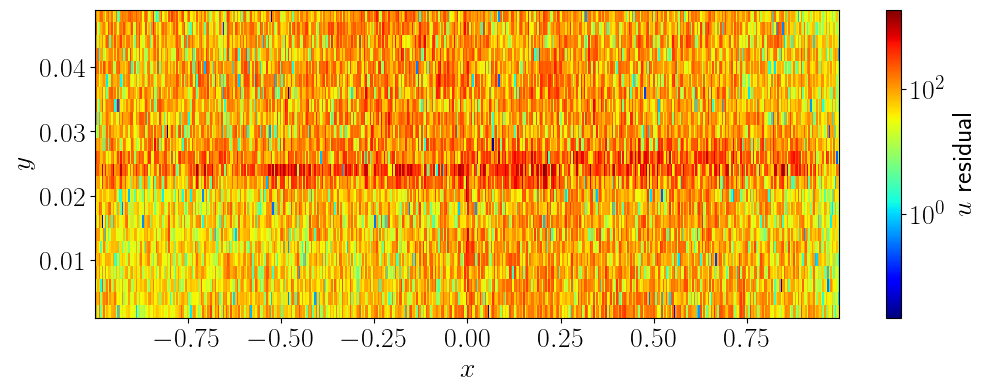

/tmp/ipykernel_63601/3738650234.py:39: MatplotlibDeprecationWarning: For X (481) and Y (25) with flat shading, the expected shape of A is (24, 480). Passing A ((1, 11520)) is deprecated since 3.5 and will become an error two minor releases later.
  plt.pcolormesh(X, Y, Vres, norm=colors.LogNorm(vmin=Vres.min(), vmax=Vres.max()), cmap=cm.jet)


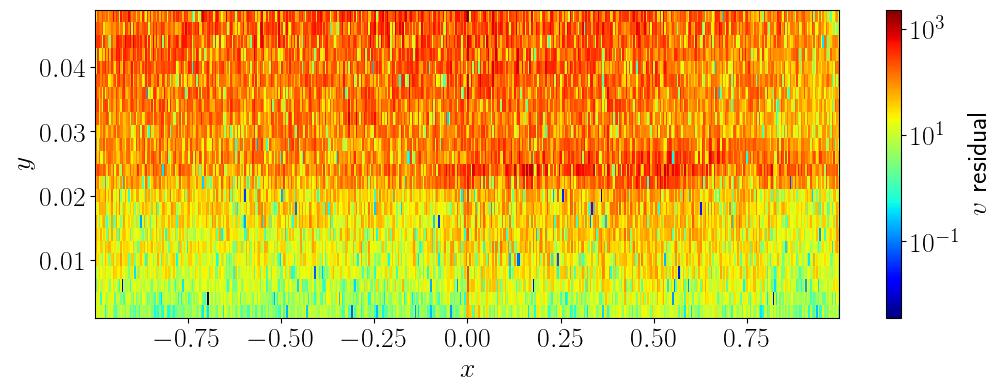

In [52]:
# plot residuals on FD grid
nx_sub, ny_sub = nx//n_sub_x, ny//n_sub_y
nxy_sub = nx_sub*ny_sub
if ddnmrom.hr:
    u_res_list = []
    v_res_list = []
    for i, s in enumerate(ddnmrom.subdomain):
        r = np.zeros(2*s.n_residual)+1e-16
        r[s.hr_ind] = res_list[i]
        u_res_list.append(r[:nxy_sub].reshape(ny_sub, nx_sub))
        v_res_list.append(r[nxy_sub:].reshape(ny_sub, nx_sub))
else:
    u_res_list = [r[:nxy_sub].reshape(ny_sub, nx_sub) for r in res_list]
    v_res_list = [r[nxy_sub:].reshape(ny_sub, nx_sub) for r in res_list]

Ures = []
Vres = []
counter = 0
for j in range(n_sub_y):
    Urow = []
    Vrow = []
    for i in range(n_sub_x):
        sub = n_sub_x*j+i
        Urow.append(u_res_list[sub])
        Vrow.append(v_res_list[sub])
    Ures.append(Urow)
    Vres.append(Vrow)
Ures = np.abs(np.bmat(Ures))
Vres = np.abs(np.bmat(Vres))        

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, Ures, norm=colors.LogNorm(vmin=Ures.min(), vmax=Ures.max()), cmap=cm.jet)
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar(label='$u$ residual')
plt.show()

plt.figure(figsize=(12, 4))
plt.pcolormesh(X, Y, Vres, norm=colors.LogNorm(vmin=Vres.min(), vmax=Vres.max()), cmap=cm.jet)
plt.xlabel('$x$')
plt.ylabel('$y$')
cb = plt.colorbar(label='$v$ residual')
plt.show()

In [53]:
# net_folder1 = './trained_nets/nx_480_ny_24_mu_0.1_2x_by_2y/'
# net_name = 'ld_10_rnnz_10_rshift_10_Sigmoid_batch_32_AbsMSEloss_4200snaps.p'
# filename = net_folder1 + 'sub_1of4/interior/' + net_name
# net_dict = torch.load(filename)
# de_net = net_dict['decoder']
# de_net

In [54]:
# if 'net.2.bias' in de_net:
#     print('Deleting old NNs...')
#     for phase in ['interior', 'interface']:
#         for sub in range(n_sub):
#             os.remove(net_folder1+f'sub_{sub+1}of{n_sub}/{phase}/'+net_name)
#     print('All done!')
# else:
#     print('all good')

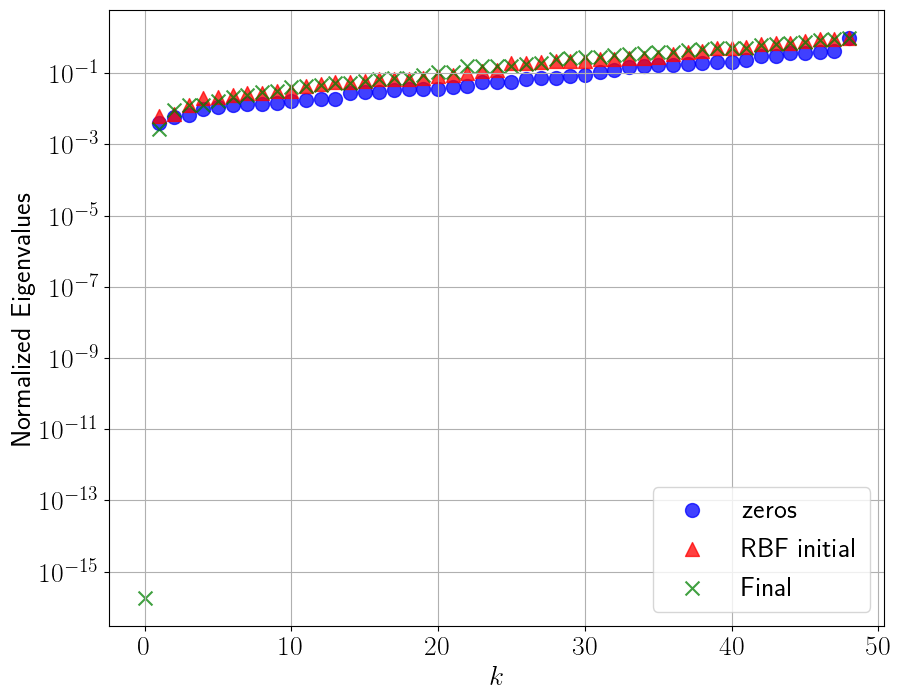

# DoF = 49
# weak constraints = 1

          Zeros     RBF      Final
# Pos.      48       48        49
# Neg.       1        1         0


In [55]:
w_opt = np.array([])
for i in range(ddnmrom.n_sub):
    w_opt = np.concatenate([w_opt, w_intr[i], w_intf[i]])
w_opt = np.concatenate([w_opt, lam_opt])

eig_list = []
for vec in [np.zeros(w0.shape), w_rbf, w_opt]:
    rhs, KKT = ddnmrom.FJac(vec)
    eigs = la.eigh(KKT.toarray(), eigvals_only = True)
    eig_list.append(eigs/eigs.max())
    
plt.figure(figsize=(10, 8))
plt.scatter(np.arange(eig_list[0].size), eig_list[0], s=100, c='blue', marker='o', label='zeros', alpha=0.75)
plt.scatter(np.arange(eig_list[0].size), eig_list[1], s=100, c='red', marker='^', label='RBF initial', alpha=0.75)
plt.scatter(np.arange(eig_list[0].size), eig_list[2], s=100, c='green', marker='x', label='Final', alpha=0.75)
plt.yscale('log')
# plt.xscale('log')
plt.ylabel('Normalized Eigenvalues')
plt.xlabel('$k$')
plt.grid()
plt.legend()
plt.show()

print(f'# DoF = {ndof_rom}')
print(f'# weak constraints = {ddnmrom.n_constraints}\n')
print('          Zeros     RBF      Final')
print(f'# Pos.      {np.sum(eig_list[0]>0):2d}       {np.sum(eig_list[1]>0):2d}        {np.sum(eig_list[2]>0):2d}')
print(f'# Neg.      {np.sum(eig_list[0]<0):2d}       {np.sum(eig_list[1]<0):2d}        {np.sum(eig_list[2]<0):2d}')